In [1]:
%%capture
import stata_setup, os
if os.name == 'nt':
    stata_setup.config('C:/Program Files/Stata17/','mp')
else:
    stata_setup.config('/usr/local/stata17','mp')

In [2]:
%%stata -qui

use "../data/data", clear
rename log_flesch_kincaid_grade_level FKG
quietly tabulate year, generate(y_)
quietly tabulate cluster, generate(c_)

local journals  ecm jpe qje res  //AER based category

local jel_imp a_imp b_imp c_imp  e_imp f_imp g_imp h_imp i_imp j_imp k_imp /// 
		l_imp m_imp n_imp o_imp p_imp q_imp r_imp y_imp z_imp // D JEL based case

## Poisson Regression

We are interested in modelling the number of sentences in an abstract in excess of 3 (5\% of articles have at most 3 sentences), i.e., our model is
$$
\mathbb{E}[\texttt{Excess Sentences}|\texttt{log(Number authors)},\texttt{log(Number pages)},\texttt{Both genders},\texttt{Proportion women}]\\\
= \exp{\left(\beta_1\log(\text{Number authors})+\beta_2\log(\text{Number pages})+\beta_3\texttt{Both genders}+\theta\texttt{Proportion women}\right.}\\\
\left.+\texttt{Journals}+\texttt{JEL codes}+\texttt{Cluster}+\texttt{Years}+\texttt{JEL flag}+\beta_{272}\right)
$$

In [3]:
%%stata -qui
summarize num_sentences, detail
local cutoff_sentences = r(p5)
gen int excess_sentences = num_sentences - `cutoff_sentences'
replace excess_sentences = 0 if excess_sentences < 0


. set scheme s1mono

. histogram excess_sentences, discrete freq width(1)
(start=0, width=1)

. 


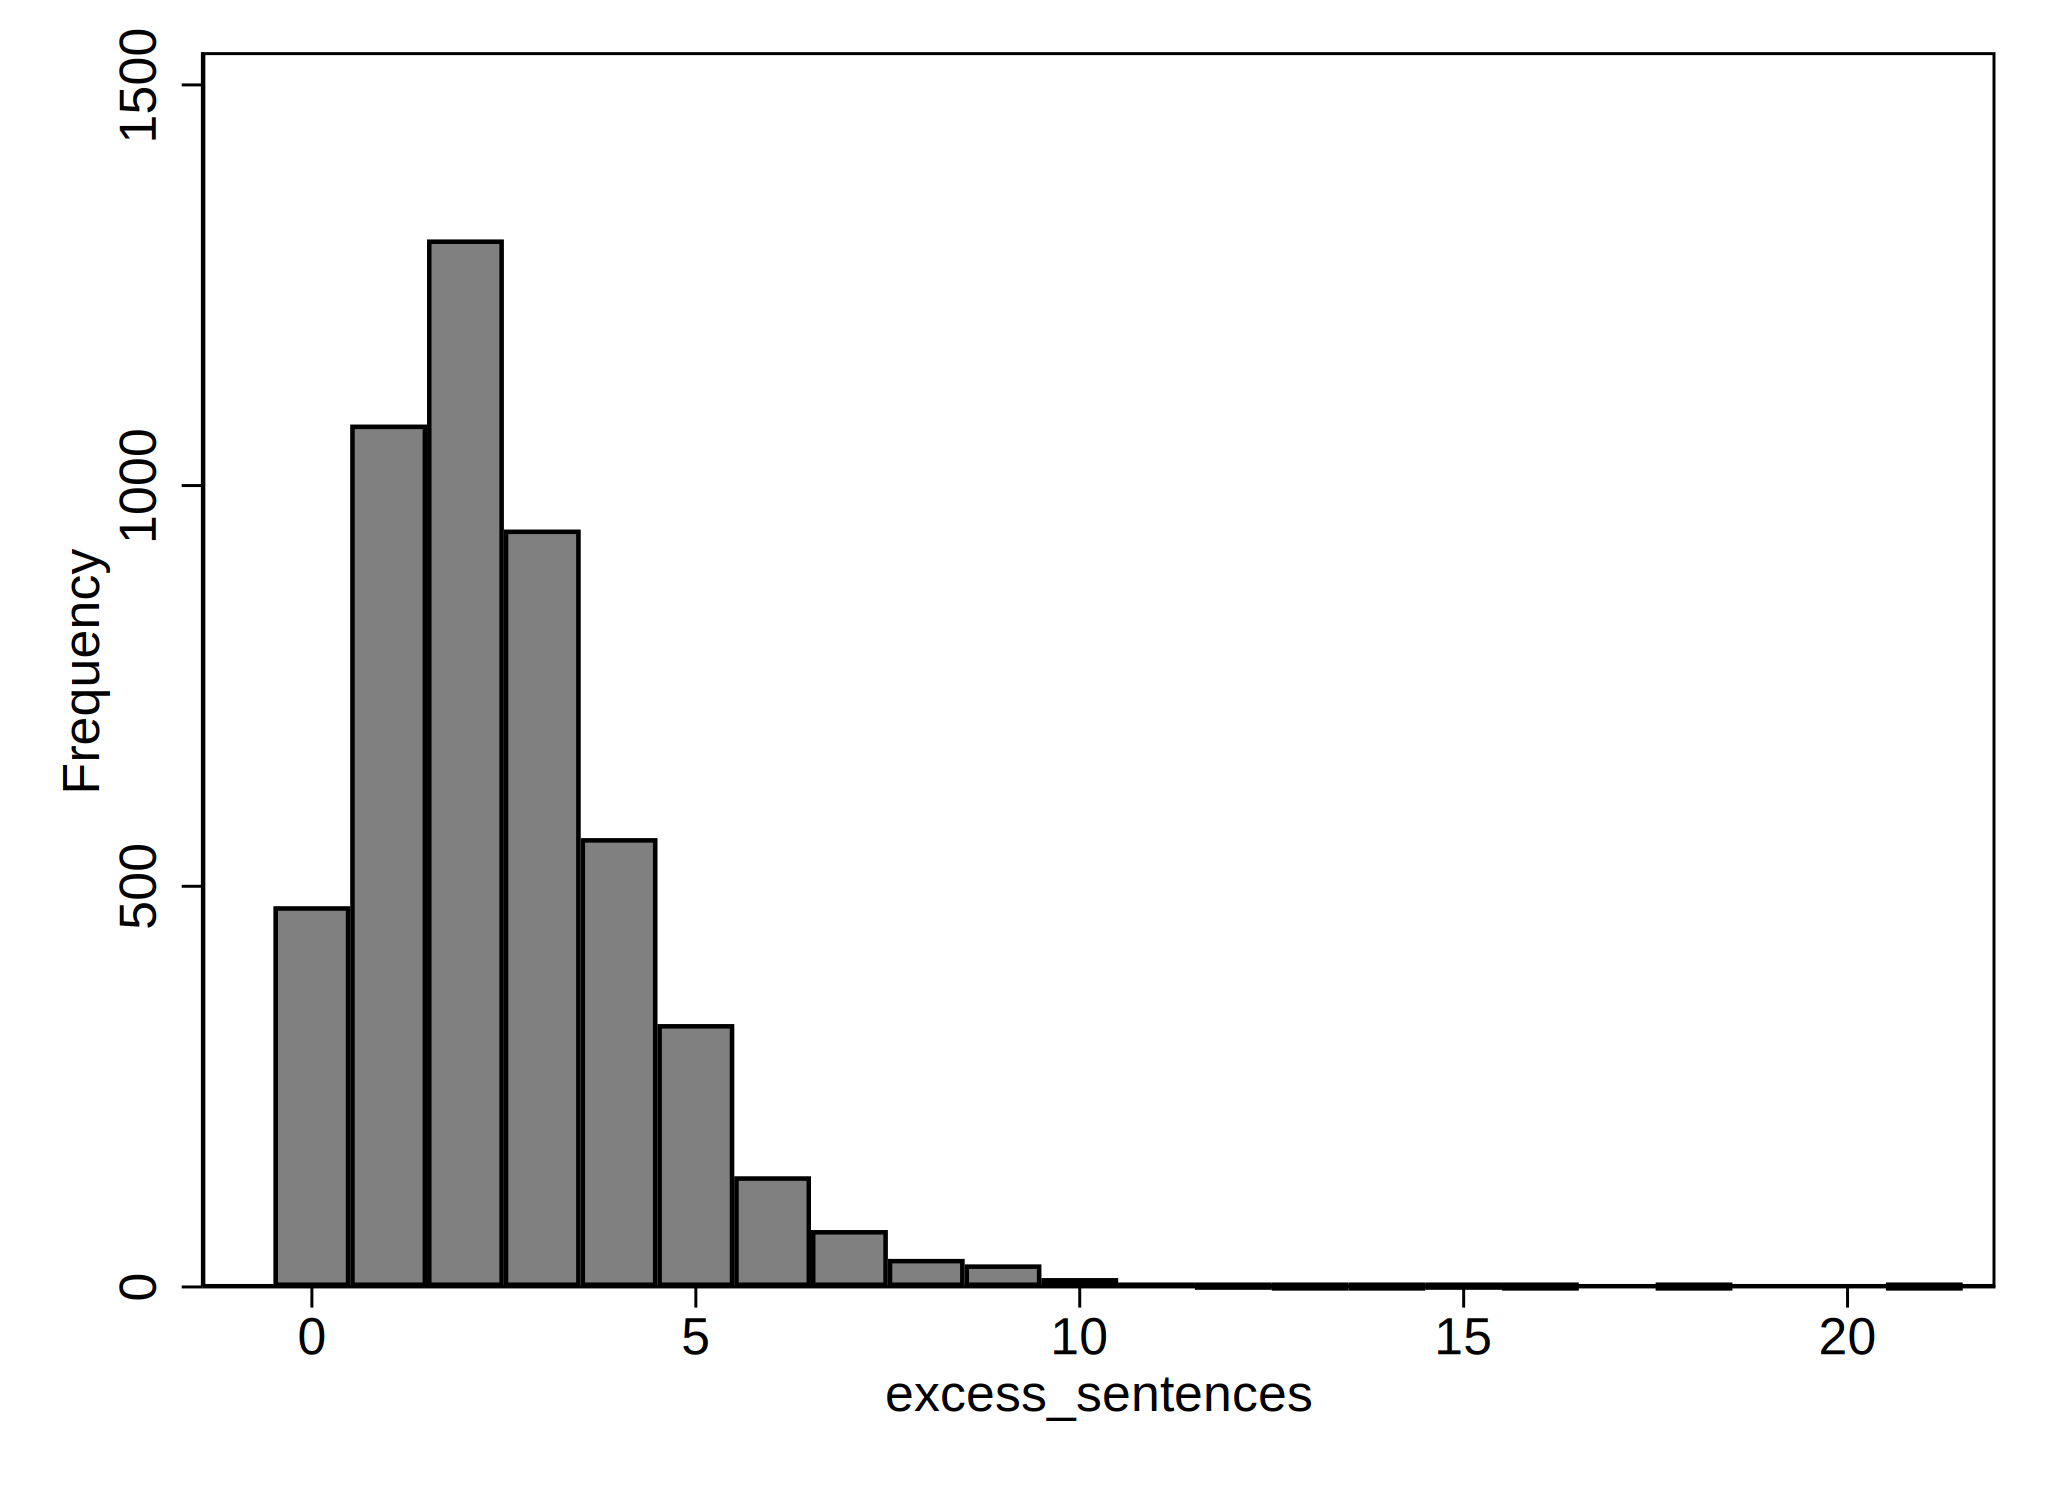

In [4]:
%%stata
set scheme s1mono
histogram excess_sentences, discrete freq width(1)

In [5]:
%%stata -qui
#delimit ;
poisson excess_sentences log_num_authors log_num_pages both_genders prop_women
			          `journals' `jel_imp' y_2-y_20  c_2-c_215  jel_flag, vce(cluster cluster);
#delimit cr

In [6]:
%%stata
estimates table, keep(log_num_authors log_num_pages both_genders prop_women jel_flag) b(%5.4f) star varwidth(50) varlabel


-----------------------------------------------------------------
                                          Variable |   Active    
---------------------------------------------------+-------------
                Logarithm of the number of authors | -0.0118     
                  Logarithm of the number of pages |  0.4093***  
    Indicator if author team includes both genders |  0.0004     
             Proportion of women among the authors |  0.0416*    
Indicator of whether the article includes a JEL cl |  0.0349*    
-----------------------------------------------------------------
                         Legend: * p<0.05; ** p<0.01; *** p<0.001


In [7]:
%%stata
nlcom (_b[log_num_pages]) (100*_b[prop_women]) (100*(exp(_b[jel_flag])-1))


       _nl_1: _b[log_num_pages]
       _nl_2: 100*_b[prop_women]
       _nl_3: 100*(exp(_b[jel_flag])-1)

------------------------------------------------------------------------------
excess_sen~s | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
       _nl_1 |   .4093298   .0162724    25.15   0.000     .3774364    .4412231
       _nl_2 |   4.157834   2.077484     2.00   0.045     .0860391    8.229628
       _nl_3 |    3.54721   1.444164     2.46   0.014     .7166994     6.37772
------------------------------------------------------------------------------


Other factors equal:
* The _elasticity_ of the expected number of sentences in excess of 3 for an article's abstract with respect to the article's number of pages is 0.41.
* If an article's authors are all women (```prop_women``` goes from 0 to 1), the abstract's expected number of sentences in excess of 3 increase by 4.16\%.
* The expected number of sentences in excess of 3 for an article's abstract is roughly 3.55\% higher when the JEL is imputed ceteris paribus.

In [8]:
%%stata -qui
egen journal1 = group(journal)
#delimit ;
ppmlhdfe excess_sentences log_num_authors log_num_pages both_genders prop_women,
                          absorb(journal1 a_imp b_imp c_imp  e_imp f_imp g_imp h_imp
                                i_imp j_imp k_imp l_imp m_imp n_imp o_imp p_imp q_imp r_imp y_imp z_imp
                                year ib0.cluster jel_flag) vce(cluster cluster);
#delimit cr

In [9]:
%%stata
estimates table, keep(log_num_authors log_num_pages both_genders prop_women) b(%5.4f) star varwidth(50) varlabel


-----------------------------------------------------------------
                                          Variable |   Active    
---------------------------------------------------+-------------
                Logarithm of the number of authors | -0.0118     
                  Logarithm of the number of pages |  0.4093***  
    Indicator if author team includes both genders |  0.0004     
             Proportion of women among the authors |  0.0416*    
-----------------------------------------------------------------
                         Legend: * p<0.05; ** p<0.01; *** p<0.001
